In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import missingno as msno

# !pip3 install seaborn

PATH = os.getcwd()
dataset_path = PATH + "/players_18.csv"

data = pd.read_csv(dataset_path, index_col=0)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# data

C:\Users\omarg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (81,82,83,84,85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [72]:
columns_datatypes = data.dtypes
numeric_count = len(data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns)
categorical_count = len(data.select_dtypes(include=['object']).columns)

numeric_count, categorical_count

(59, 50)

### Data Columns

```py
columns_list = ['player_url','short_name','long_name','player_positions','overall','potential','value_eur','wage_eur','age','dob','height_cm','weight_kg','club_team_id','club_name','league_name','league_level','club_position','club_jersey_number','club_loaned_from','club_joined','club_contract_valid_until','nationality_id','nationality_name','nation_team_id','nation_position','nation_jersey_number','preferred_foot','weak_foot','skill_moves','international_reputation','work_rate','body_type','real_face','release_clause_eur','player_tags','player_traits','pace','shooting','passing','dribbling','defending','physic','attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed','movement_agility','movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots','mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision','mentality_penalties','mentality_composure','defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed','ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk','player_face_url','club_logo_url','club_flag_url','nation_logo_url','nation_flag_url']
```

From a quick look we can assume what columns we would take as features and what could be classified.
Numeric features 59
Categorical / Mixed features 50

some features we can use `[wage, value, height, weight, overall, potential, skills, age, contract, pace, work rate, preferred_foot]`

As a start we'll plot the missing values, columns correlation to help us understand more about the dataset

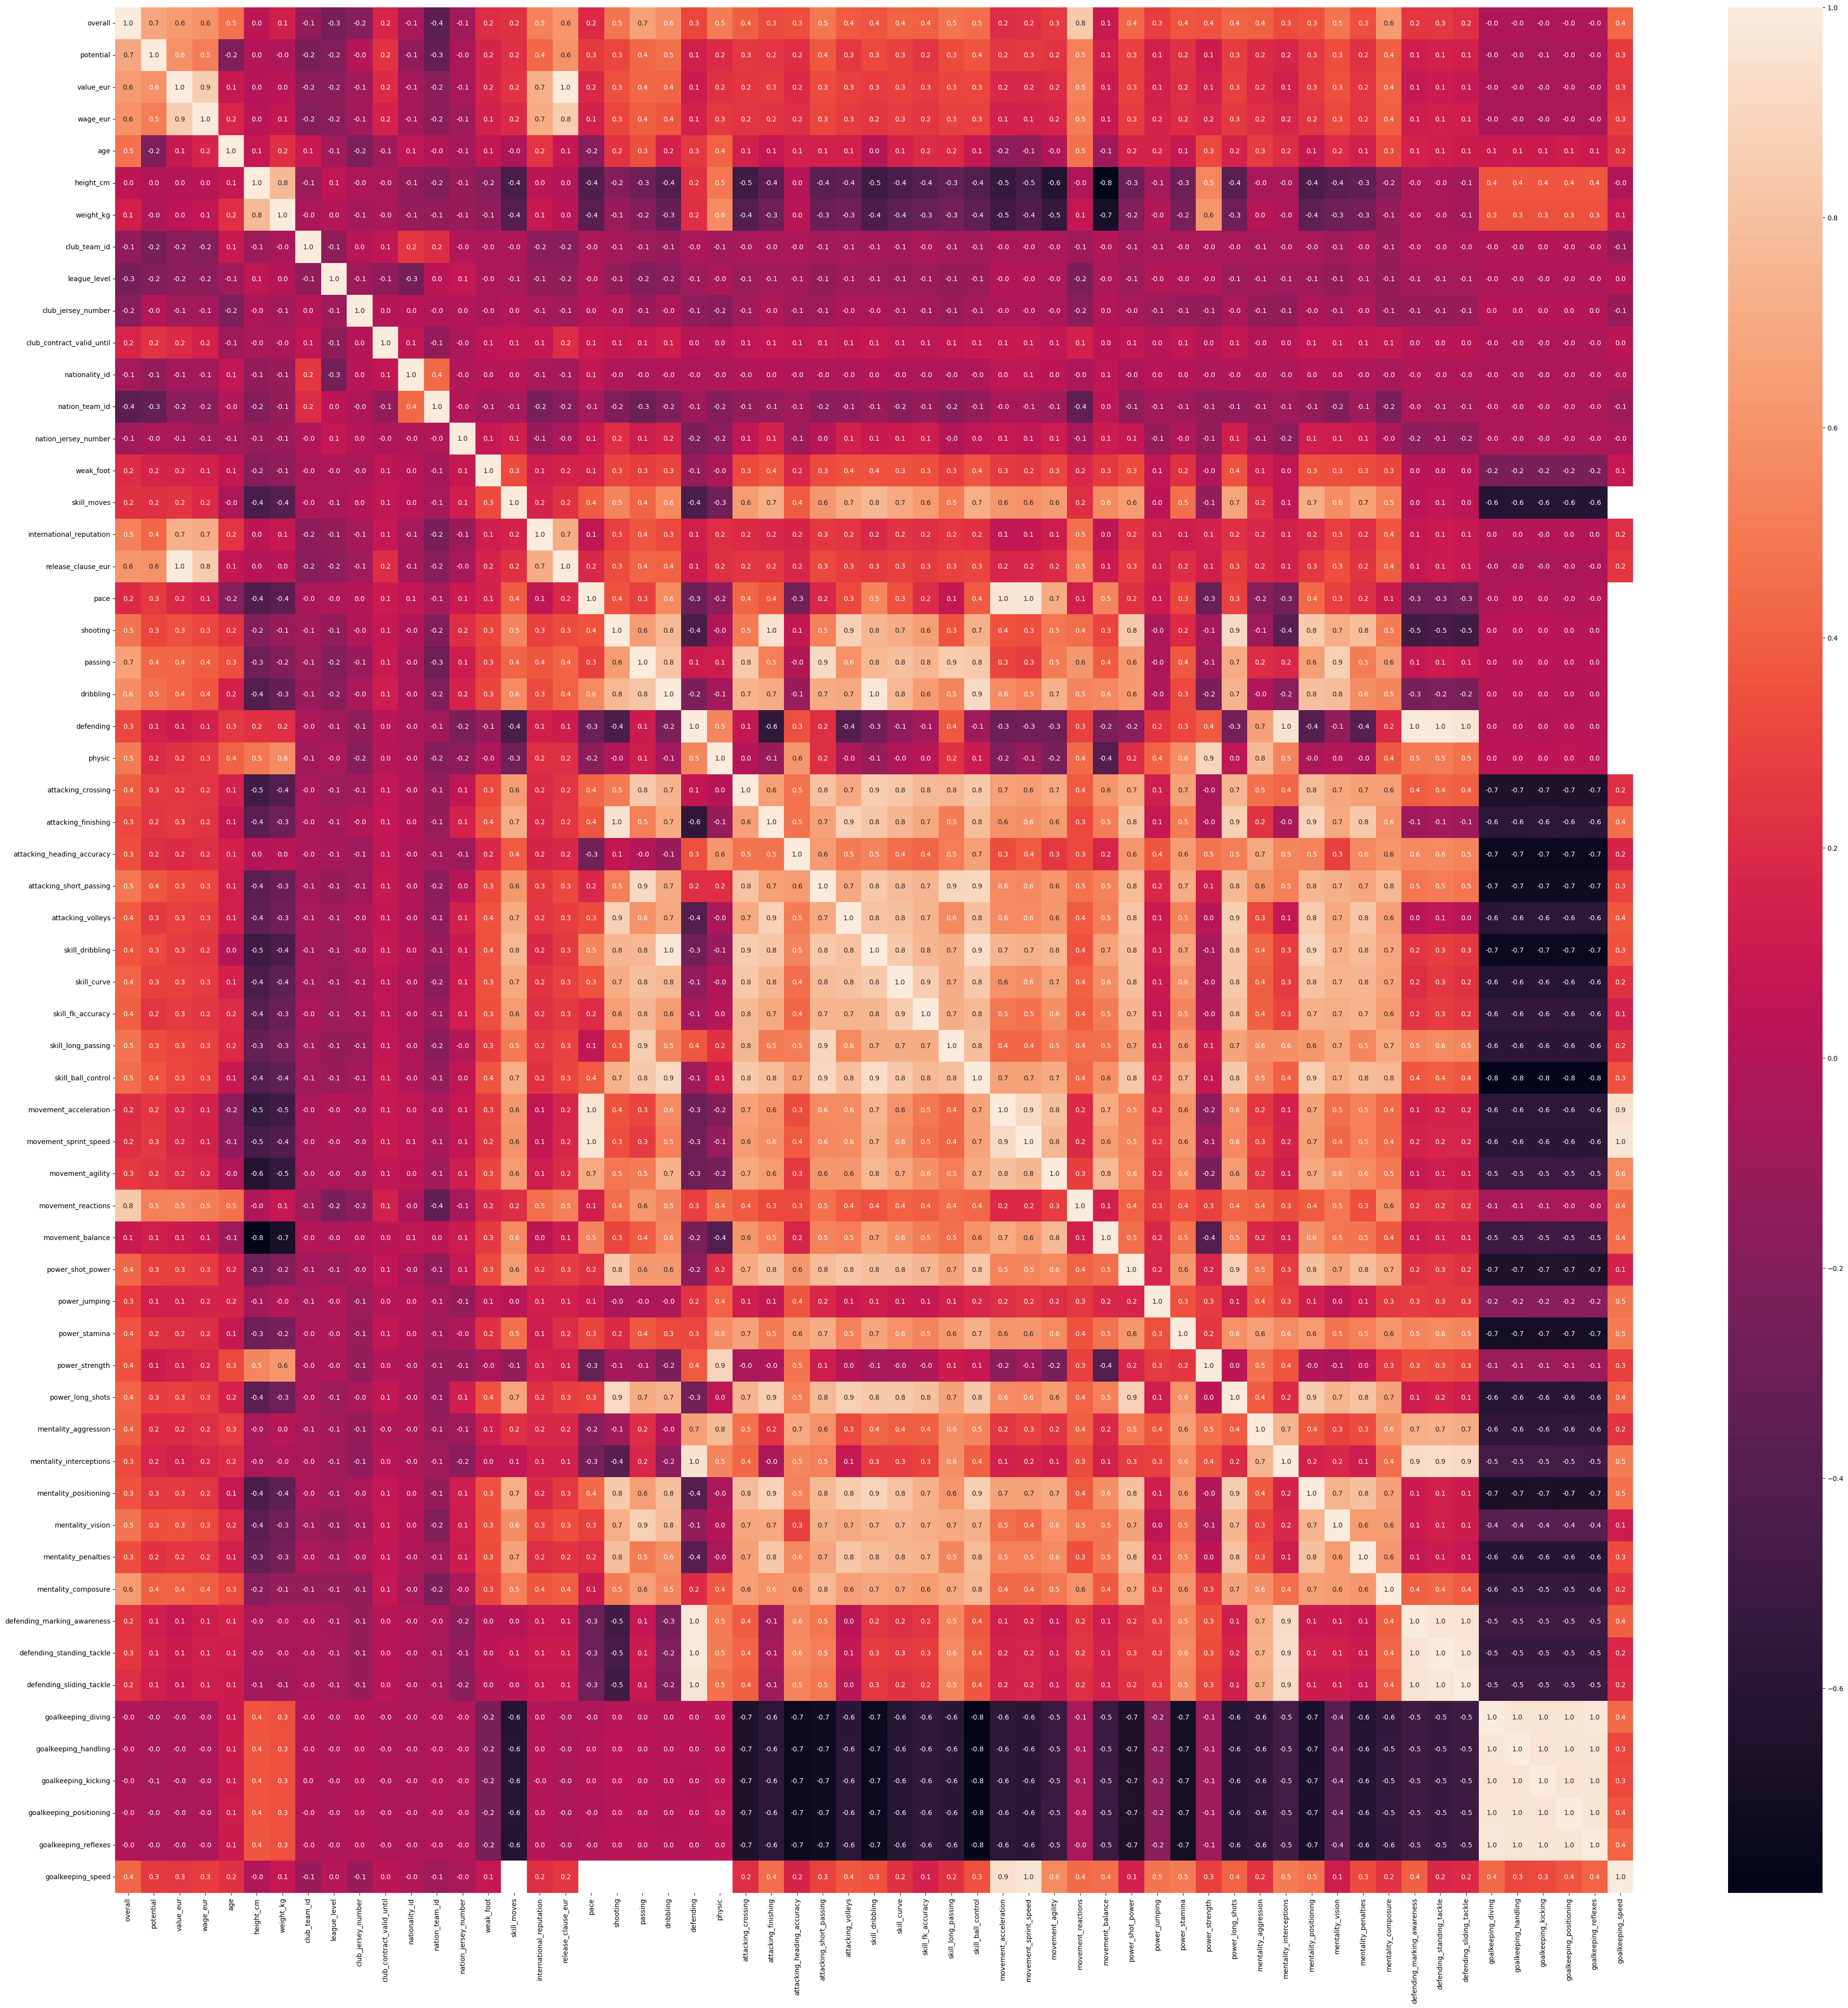

In [5]:
# Heatmap Visualization of column correlation
plt.subplots(figsize=(50, 50))
correlation = data.corr()
sns.heatmap(data=correlation, annot=True, fmt=".1f")
plt.show()

<AxesSubplot: >

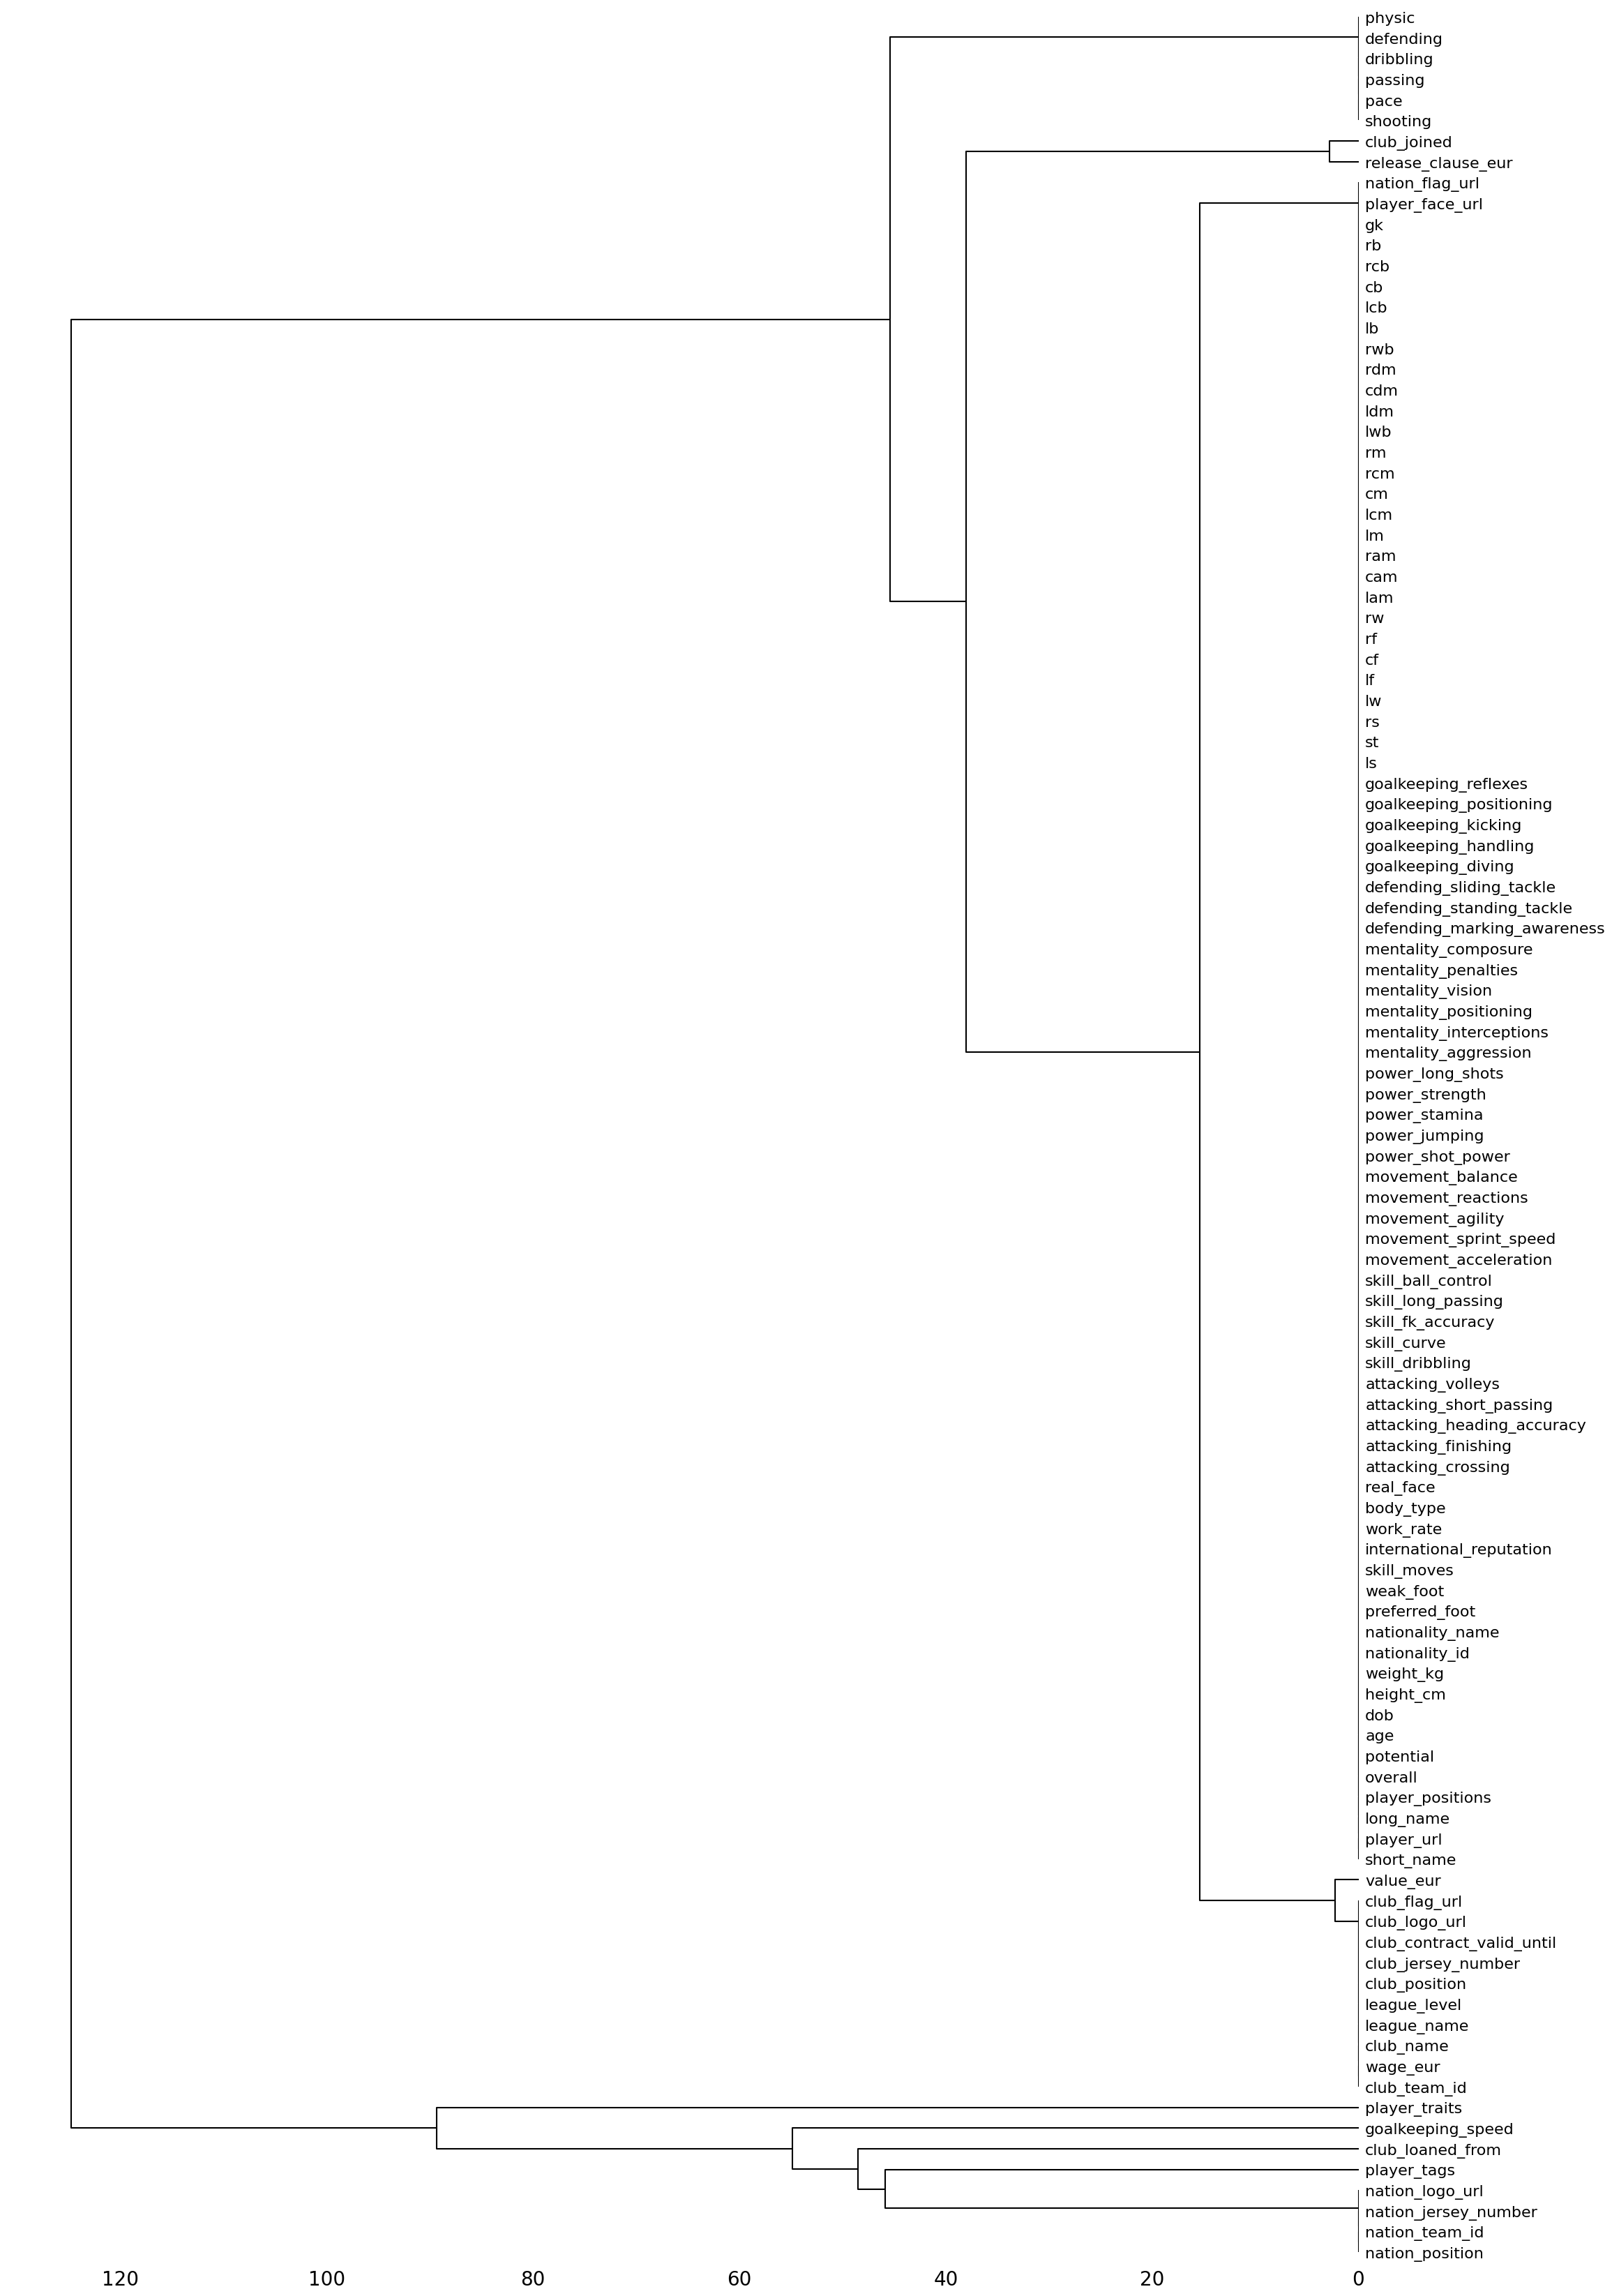

In [28]:
msno.dendrogram(data)

<AxesSubplot: >

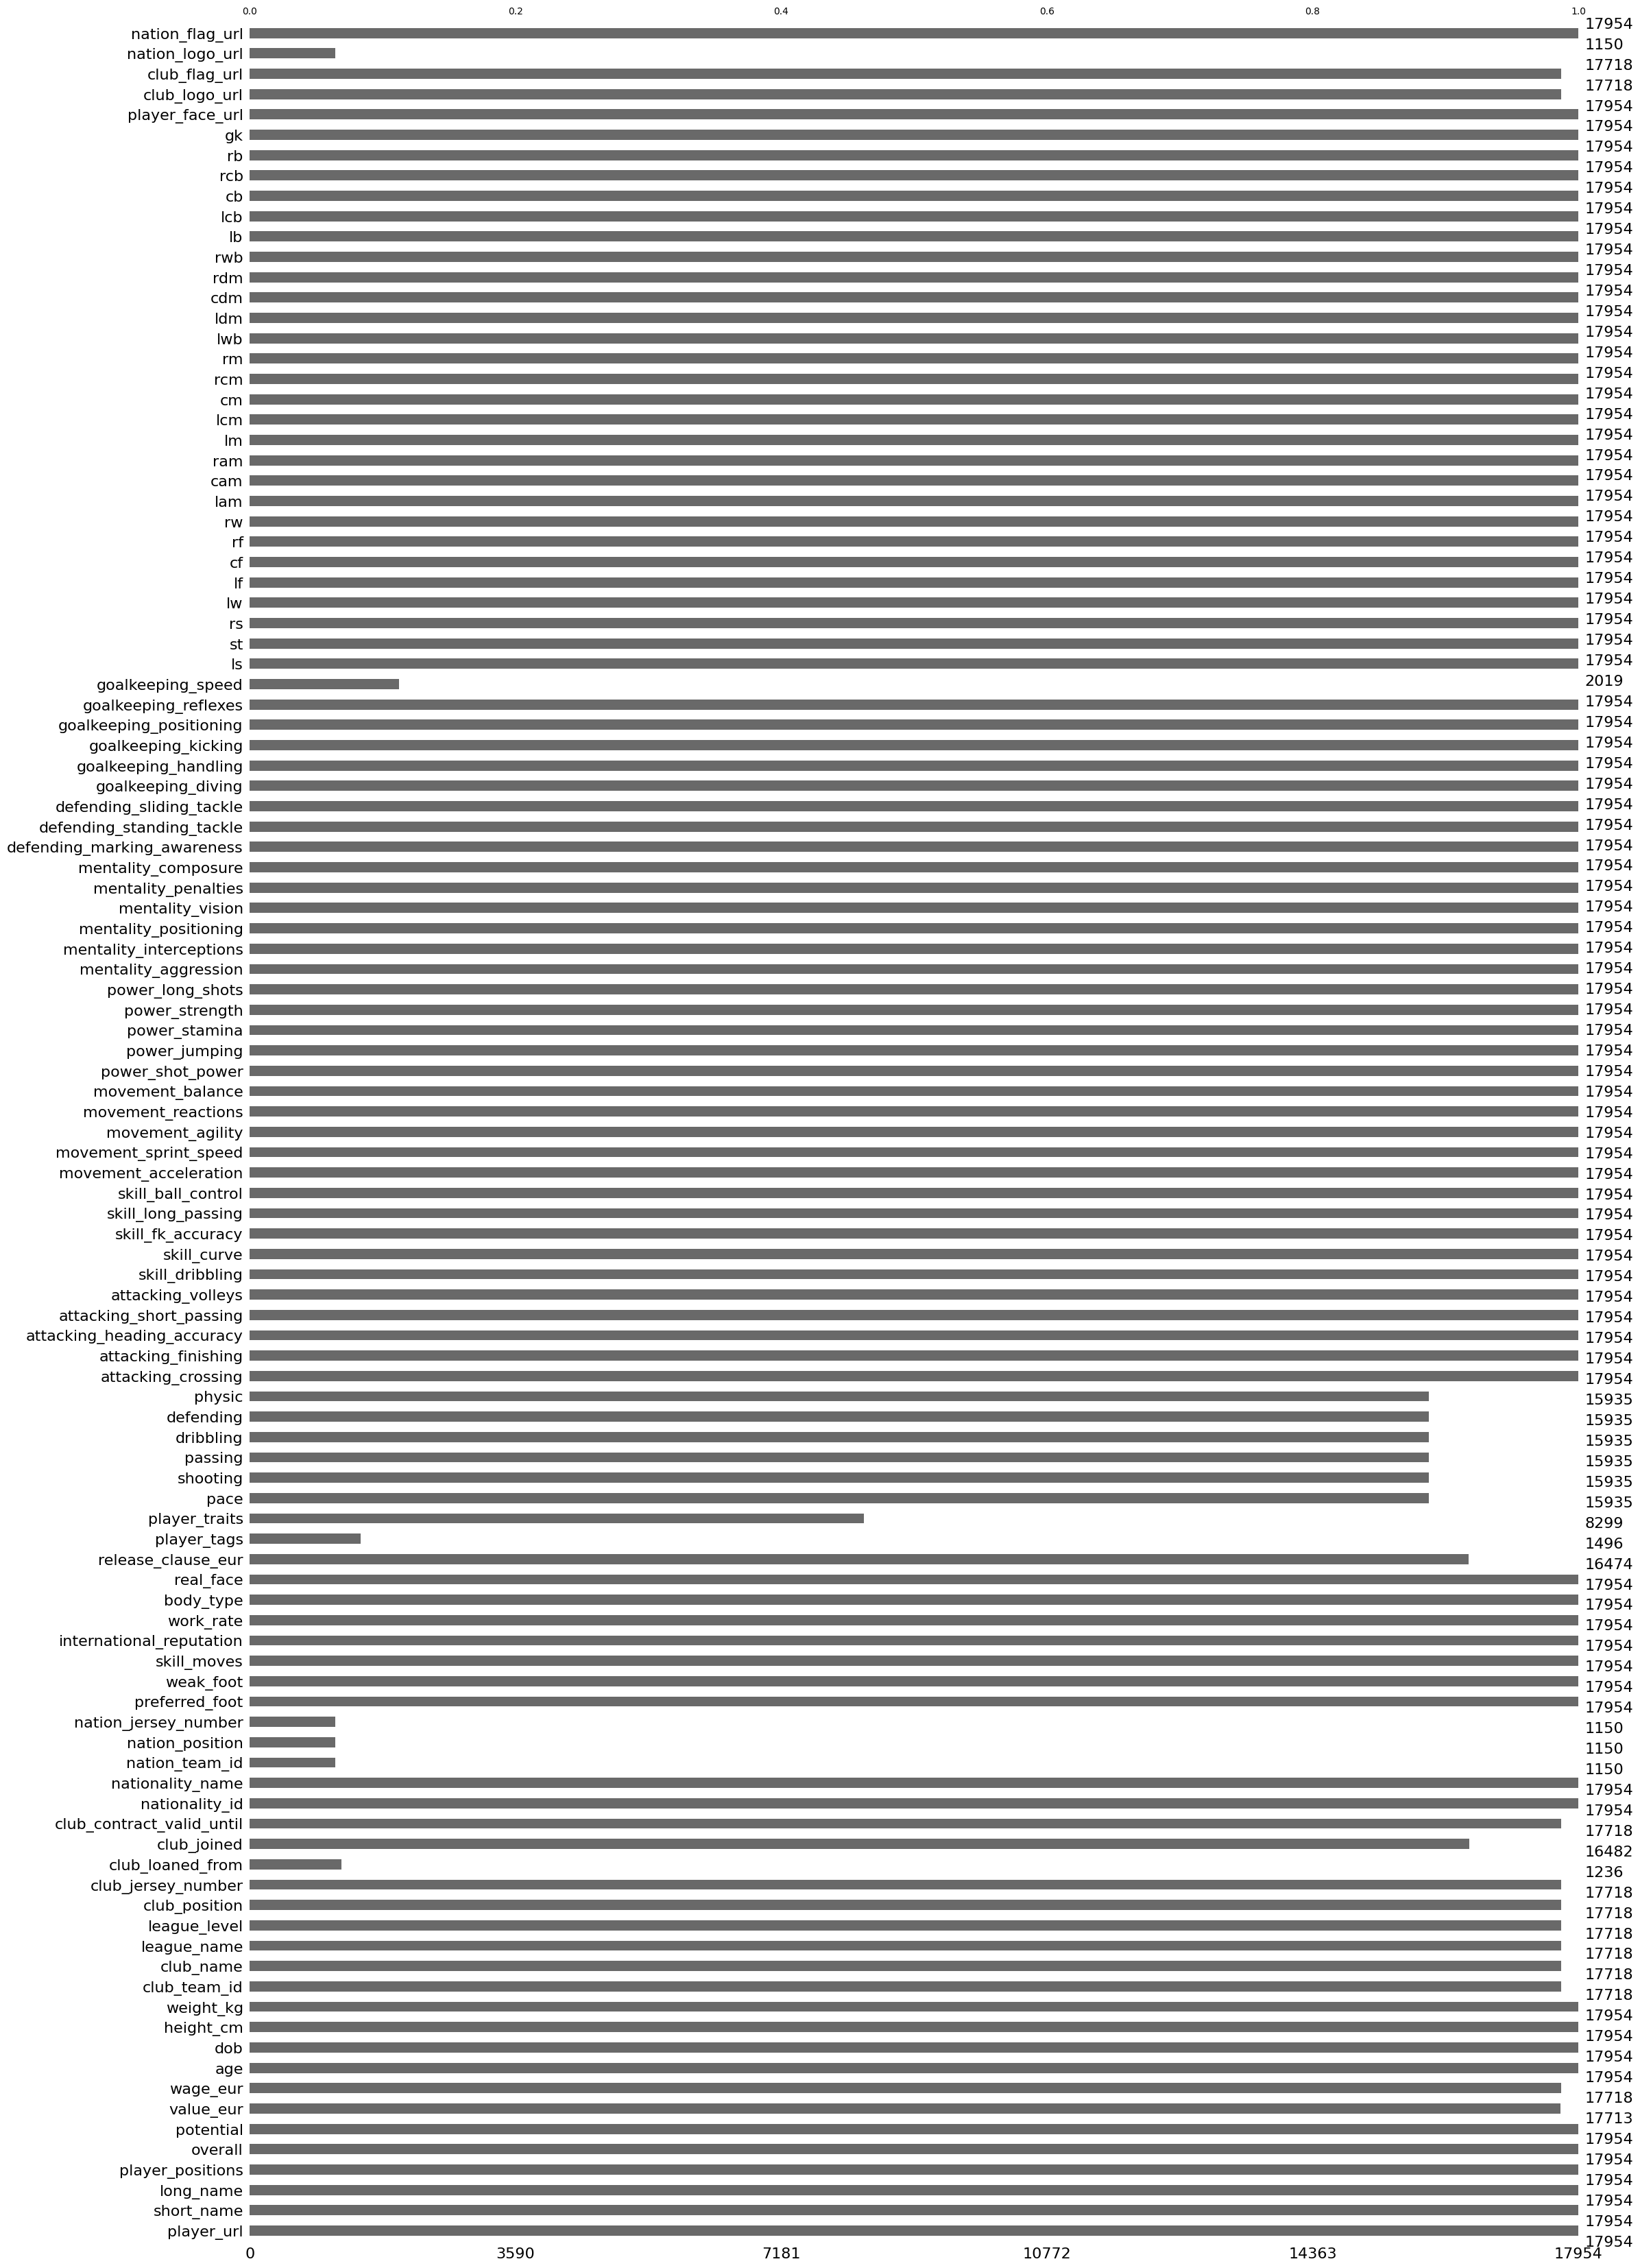

In [26]:
# Missing Values

msno.bar(data)

### Missing Values

We can acknowledge from the plot above that most columns have missing values as the positions, work rate, weak foot, skills, long_name, club_name, club_jersey_number, etc

From the previous correlation plots we can assume that club metadata (jersey num, club name, club joined) are related which makes sense when a value is missing the rest will be.

Not sure why full name and the skills is missing but maybe the dataset is incomplete.

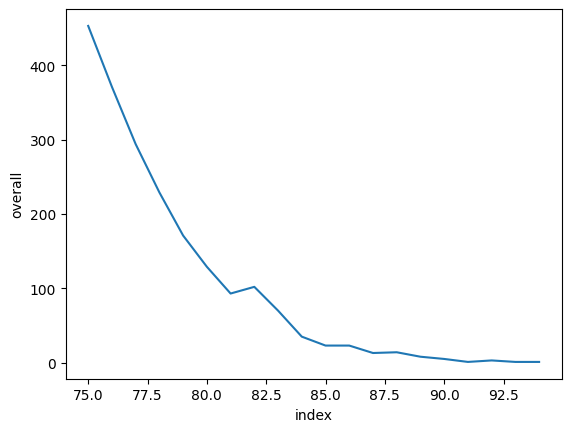

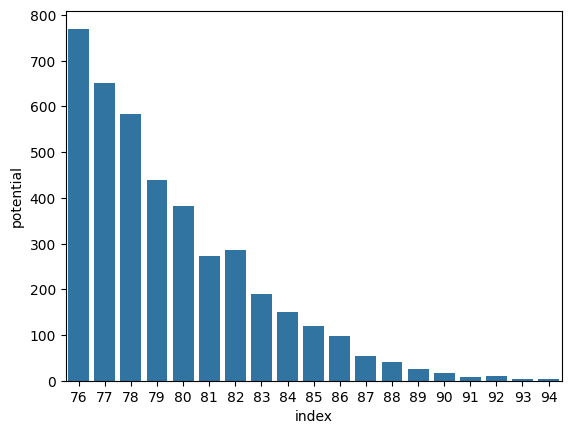

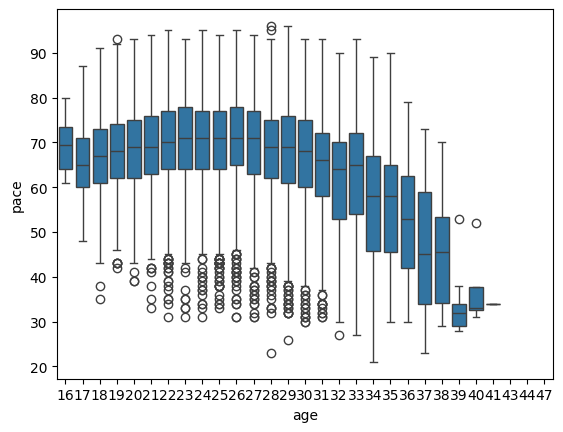

In [32]:
# Relation between columns and analysis

ret_data = data['overall'].value_counts(normalize=False, ascending=False).reset_index().sort_values(by='index', ascending=True)[29:]
sns.lineplot(data=ret_data, x="index", y="overall")
plt.show()

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html
ret_data = data['potential'].value_counts(normalize=False, ascending=False).reset_index().sort_values(by='index', ascending=True)[29:]
sns.barplot(data=ret_data, x="index", y="potential")
plt.show()

# Relation between Age and Pace
sns.boxplot(data=data, x="age", y="pace")
plt.show()

# The more the player gets older his pace gets lower which makes sense.

There's 31 players from Egypt
The average wage is 11393.0€
The percentage of players with more than average is 22.4%


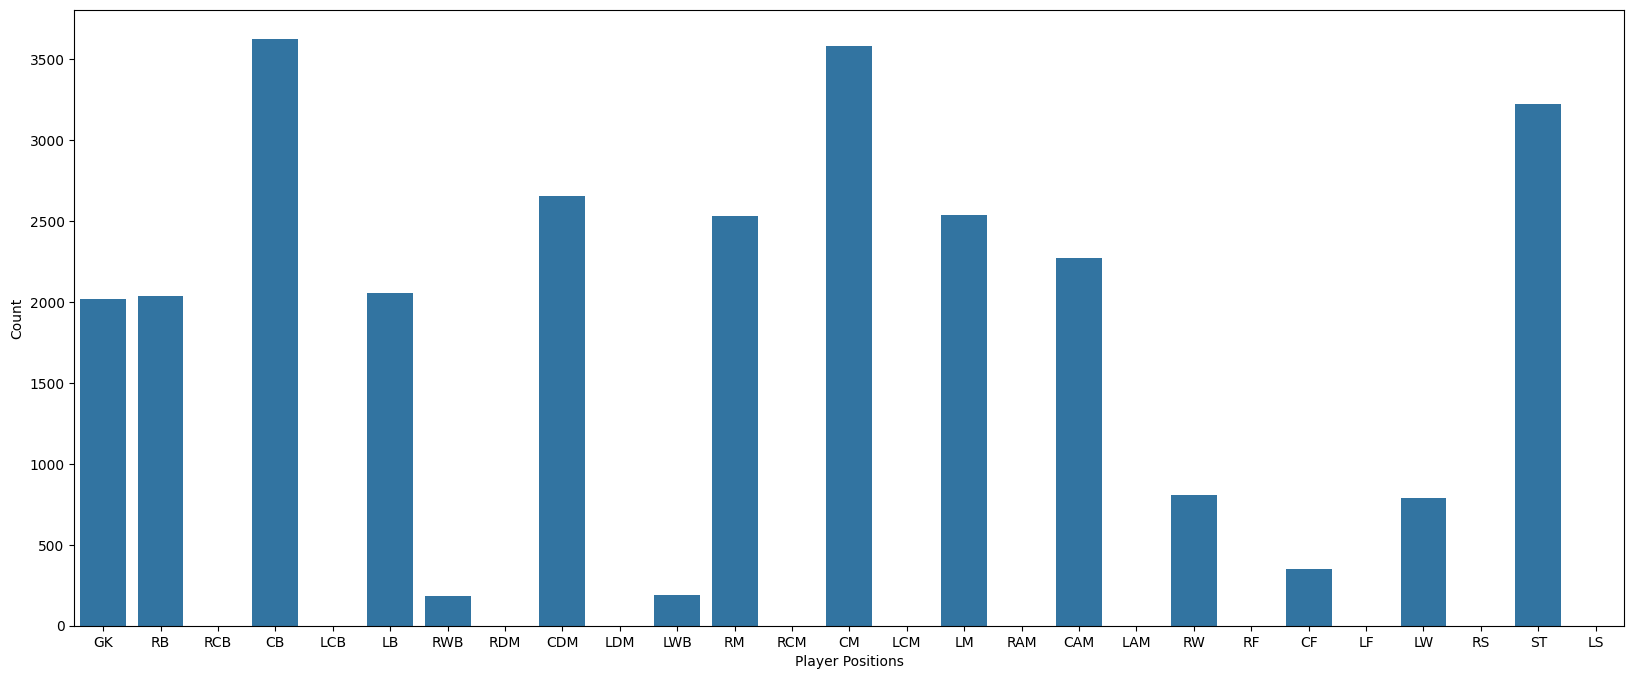

In [89]:
# Stats of players

# How many players from a country?
country = "Egypt"
player_count = len(data.loc[data['nationality_name'] == country])
print(f"There's {player_count} players from {country}")

# What's the average wage?
average_wage = float(data[['wage_eur']].mean(), )
print(f"The average wage is {str('%.1f' % average_wage)}€")

# How many players have more than average wage?
player_count = len(data.loc[data['wage_eur'] > average_wage])
all_players_count = len(data)
percentage = (player_count/all_players_count) * 100
print(f"The percentage of players with more than average is {str('%.1f' % percentage)}%")

# What's the most chosen / preferred position to players?

positions = ["GK", "RB", "RCB" ,"CB", "LCB", "LB", "RWB", "RDM", "CDM", "LDM", "LWB", "RM", "RCM", "CM", "LCM", "LM", "RAM", "CAM", "LAM", "RW", "RF", "CF", "LF", "LW", "RS", "ST", "LS"]

position_counts = data['player_positions'].str.split(', ').explode().value_counts()

# Reindex to include all positions
position_counts = position_counts.reindex(positions, fill_value=0)
plt.figure(figsize=(20,8))
plt.xlabel("Player Positions")
plt.ylabel("Count")
sns.barplot(x=position_counts.index, y=position_counts.values)
plt.show()

We can conclude from the stats above that the positions CM (centre midfielder) and CB (Centre Back) are the most chosen positions and that Damn not everyone has a good football career 

### Conclusion

Based on the information we've above we can choose positions as a classification task and for regression we can choose wage to predict how much he'll earn or he's worth in a club.

We'll create multiple transformers to clean the dataset and create a numerical preprocessed dataset that we can use later on for prediction

Column Descriptions to make it easier for us in creating the transformers

- Work Rate: The column has High/Low which is considered High Attack Rate and Low Defense Rate so Attack/Defense, in the transformer we'll create new features Attack Rate and Defense Rate

- Preferred Foot: The column can have two values Right and Left we can consider them as numerical features by setting them to Booleans or we can use them as categorical features.

- Real Face: That column is for Fifa which determines if the player has a real face so it's yes, no we can set them as booleans also.

- Height, Weight: These columns are set to CM Height and KG Weight can use them with Age to add a new feature BMI or we can simply use them as they are. (numerical features)

- Club Contract Date: That column with the club_joined date can be used to generate a new feature Club Contract Length as player's contracts typically is about the contract length and wage more than dates, and the contract date column itself is with datetime type we can convert it into a timestamp int32 which will make it a numerical feature useful for us. 

- Positions: We've a column regarding a player position and a list of columns for each position eg (20+4, 91+3), This typically means that the first part 20 is the overall rating for the player in that position and the 4 is the additional rating suggesting the player may perform well in that position. I don't know for sure but that's what ChatGPT said

ChatGPT answer regarding Positions:
```
20+4: In this notation, "20" represents the player's overall rating for that position, and "+4" represents the player's additional rating specifically for that position. It suggests that the player may not be primarily suited for that position but can still perform reasonably well if deployed there.
```

In [177]:
# Preprocessing Dataset

from sklearn import preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import OneHotEncoder
import re, time, copy
from datetime import datetime

# Transformers
class WorkRateTransformer(TransformerMixin, BaseEstimator):
    @staticmethod
    def applied(value_type):
        def subapplied(value):
            if value is np.nan or value == "nan":
                return value
    
            return value.split("/")[value_type].strip()
        
        return subapplied
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Rate Attack'] = X['work_rate'].astype('str').apply(WorkRateTransformer.applied(0))  
        X['Rate Defense'] = X['work_rate'].astype('str').apply(WorkRateTransformer.applied(1))
        return X

class BoolTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, col):
        self.col = col
        
    @staticmethod
    def applied(value):
        return (value.lower() == "right" or value.lower() == "yes")
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X[self.col] = X[self.col].astype('str').apply(BoolTransformer.applied).astype('bool')
        return X

# 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk',

class PositionTransformer(TransformerMixin, BaseEstimator):
    @staticmethod
    def applied(value):
        if "," in value:
            import random
            return random.choice(['attack', 'midfield', 'defense'])
        
        return value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        
        X['Position 1'] = X['player_positions'].replace(to_replace=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW'], value="attack")
        X['Position 1'] = X['Position 1'].apply(PositionTransformer.applied)
        X['Position 1'] = X['Position 1'].replace(['LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM'], "midfield")
        X['Position 1'] = X['Position 1'].replace(['RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'], "defense")
        X['Position 1'] = X['Position 1'].replace(['GK'], "goalkeeper")
        
        return X

# Recommended by ChatGPT as we've found above.
class PositionRatingTransformer(TransformerMixin, BaseEstimator):
    @staticmethod
    def applied(value_type):
        def subapplied(value):
            if value is np.nan or value == "nan":
                return value
            
            if "+" in value:
                return float(value.split("+")[value_type])
            elif "-" in value:
                return float(value.split("-")[value_type])
        
        return subapplied
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for position in positions:
            X[f'{position} Rating'] = X[position.lower()].astype('str').apply(PositionRatingTransformer.applied(0))
            X[f'{position} Additional Rating'] = X[position.lower()].astype('str').apply(PositionRatingTransformer.applied(0))
        
        return X

class ContractLengthTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X['Contract Length'] = np.nan # init
        
#         if (np.isnan(joined_date) or np.isnan(valid_until)):
#             X['Contract Length'] = np.nan
#         else:
#             X['Contract Length'] = int(valid_until) - int(joined_date)

    
        for index, row in X.iterrows():
            if (np.isnan(row['club_joined']) or np.isnan(row['club_contract_valid_until'])):
                continue
            X.at[index, 'Contract Length'] = int(row['club_contract_valid_until']) - int(row['club_joined'])
        
        return X
    
class DateTimeTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, col):
        self.col = col
    
    @staticmethod
    def applied(time_str):
        if time_str is np.nan or time_str == "nan":
            return time.mktime(datetime(2015, 1, 1).timetuple())
        
        try:
            time_integer = int(float(time_str))
            return time.mktime(datetime(time_integer, 1, 1).timetuple())
        except:
            time_split = time_str.split("-")
            year = int(time_split[0])
            month = int(time_split[1])
            day = int(time_split[-1])
            
            return time.mktime(datetime(year, month, day).timetuple())
              
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.col] = X[self.col].astype('str').apply(DateTimeTransformer.applied).astype('int')
        return X

transformers = {
    "position_rating_transformer": PositionRatingTransformer(),
    "player_position_transformer": PositionTransformer(),
    "work_rate_transformer": WorkRateTransformer(),
#     "transformer_bool": BoolTransformer("preferred_foot"), 
    "transformer_bool_real_face": BoolTransformer("real_face"), 
    "transform_club_contract_valid_until": DateTimeTransformer("club_contract_valid_until"), 
    "transform_club_joined": DateTimeTransformer("club_joined"), 
    "contract_length_transformer": ContractLengthTransformer()}
pipeline_config_transformers = [(pn, pv) for pn, pv in transformers.items()] 
pipeline_config = Pipeline(pipeline_config_transformers)
new_data = pipeline_config.transform(copy.copy(data))

extras = ['weak_foot', 'skill_moves', 'international_reputation', 'player_positions']
skills = ["passing", "shooting", "dribbling", "defending", 'physic','attacking_crossing', 'attacking_finishing',
          'attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve',
          'skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed',
          'movement_agility','movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina',
          'power_strength','power_long_shots','mentality_aggression','mentality_interceptions','mentality_positioning',
          'mentality_vision','mentality_penalties','mentality_composure','defending_marking_awareness','defending_standing_tackle',
          'defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning',
          'goalkeeping_reflexes','goalkeeping_speed']
rating_positions = []
for position in positions:
    rating_positions.append(f"{position} Rating")
    rating_positions.append(f"{position} Additional Rating")
    
wanted = ["wage_eur", "value_eur", "overall", "age", "height_cm" , "weight_kg", "potential", "preferred_foot", "real_face", "club_contract_valid_until", "club_joined", "Rate Attack", "Rate Defense", "pace", "physic", "Position 1", "release_clause_eur", "Contract Length"] + rating_positions + skills + extras

# Rename columns for easier reading
renaming = {
    "value_eur": "Value",
    "real_face": "Real Face",
    'wage_eur': "Wage",
    'overall': "Overall",
    'height_cm': "Height",
    "weight_kg": "Weight",
    "potential": "Potential",
    "preferred_foot": "Preferred Foot",
    "club_contract_valid_until": "Contract Valid Until",
    "club_joined": "Joined",
    "age": "Age",
    "pace": "Pace",
    "release_clause_eur" :"Release Clause",
    "weak_foot": "Weak Foot",
    "skill_moves": "Skill Moves",
    "player_positions": "Positions",
    "international_reputation": "International Reputation",
#     "passing": "Passing",
#     "shooting": "Shooting",
#     "dribbling": "Dribbling",
#     "defending": "Defending",
#     "physic": "Physic",
#     "attacking_crossing": "Attacking Crossing",
#     "attacking_finishing": "Attacking Finishing",
#     "attacking_heading_accuracy": "Attacking Heading Accuracy",
#     "attacking_short_passing": "Attacking Short Passing",
#     "attacking_volleys": "Attacking Volleys",
#     "skill_dribbling": "Skill Dribbling",
#     "skill_curve": "Skill Curve"
}

final_data = new_data[wanted]
final_data = final_data.rename(columns=renaming)
final_data.to_csv(os.getcwd()+'/players_18_processed.csv')
final_data[final_data['Positions'].notna()].head(5)

Wage        Value  Overall  Age  Height  Weight  Potential  \
sofifa_id                                                                   
20801      575000.0   95500000.0       94   32     185      80         94   
158023     575000.0  105000000.0       93   30     170      72         93   
167495     225000.0   61000000.0       92   31     193      92         92   
176580     500000.0   97000000.0       92   30     182      86         92   
190871     275000.0  123000000.0       92   25     175      68         94   

          Preferred Foot  Real Face  Contract Valid Until      Joined  \
sofifa_id                                                               
20801              Right       True            1609452000  1246395600   
158023              Left       True            1514757600  1088629200   
167495             Right       True            1609452000  1309467600   
176580             Right       True            1609452000  1405026000   
190871             Right       True            1640988000  1501707600   

          Rate Attack Rate Defense  Pace  physic  Position 1  Release Clause  \
sofifa_id                                                                      
20801            High          Low  90.0    80.0     defense     195800000.0   
158023         Medium       Medium  89.0    61.0      attack     215300000.0   
167495         Medium       Medium   NaN     NaN  goalkeeper     100700000.0   
176580           High       Medium  82.0    81.0      attack     198900000.0   
190871           High       Medium  92.0    60.0      attack     236800000.0   

           Contract Length  GK Rating  GK Additional Rating  RB Rating  \
sofifa_id                                                                
20801          363056400.0       20.0                  20.0       61.0   
158023         426128400.0       19.0                  19.0       57.0   
167495         299984400.0       90.0                  90.0       34.0   
176580         204426000.0       37.0                  37.0       64.0   
190871         139280400.0       20.0                  20.0       59.0   

           RB Additional Rating  RCB Rating  RCB Additional Rating  CB Rating  \
sofifa_id                                                                       
20801                      61.0        53.0                   53.0       53.0   
158023                     57.0        45.0                   45.0       45.0   
167495                     34.0        33.0                   33.0       33.0   
176580                     64.0        58.0                   58.0       58.0   
190871                     59.0        46.0                   46.0       46.0   

           CB Additional Rating  LCB Rating  LCB Additional Rating  LB Rating  \
sofifa_id                                                                       
20801                      53.0        53.0                   53.0       61.0   
158023                     45.0        45.0                   45.0       57.0   
167495                     33.0        33.0                   33.0       34.0   
176580                     58.0        58.0                   58.0       64.0   
190871                     46.0        46.0                   46.0       59.0   

           LB Additional Rating  RWB Rating  RWB Additional Rating  \
sofifa_id                                                            
20801                      61.0        66.0                   66.0   
158023                     57.0        62.0                   62.0   
167495                     34.0        36.0                   36.0   
176580                     64.0        68.0                   68.0   
190871                     59.0        64.0                   64.0   

           RDM Rating  RDM Additional Rating  CDM Rating  \
sofifa_id                                                  
20801            62.0                   62.0        62.0   
158023           59.0                   59.0        59.0   
167495          

In [202]:


classification_categorical_features = ["Rate Attack", "Rate Defense"]
classification_numerical_features = ["Age", "Overall", "Height", "Weight", "Potential", "Pace", "Release Clause"] + skills

classification_features = np.concatenate([classification_categorical_features, classification_numerical_features])

# Allows feature selection in the sci-kit pipeline, we can use TPOT to automate the entire process with preprocessing but sure.
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if(not isinstance(X, pd.DataFrame)):
            raise Exception("")

        return X[self.cols]

class RemoveColswithMissingValues(TransformerMixin, BaseEstimator):
    def __init__(self, cols, **kwargs):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame.")
            
        for col in self.cols:
            X = X[X[col].notna()]

        return X

class Normalizer(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if(not isinstance(X, pd.DataFrame)):
            raise Exception("")
            
        for col in self.cols:
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            flc = X[[col]].values.astype('float')
            scaled = scaler.fit_transform(flc)
            X[col] = scaled
       
        return X

# https://stackoverflow.com/questions/58101126/using-scikit-learn-onehotencoder-with-a-pandas-dataframe
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.get_dummies(X, dummy_na=True, drop_first=False)

from paralytics import PandasFeatureUnion
classification_pipeline_config = Pipeline(
    [
        ('missing_values', RemoveColswithMissingValues(['Positions'])),
        ('transform', PandasFeatureUnion([
            ('categories', make_pipeline(FeatureSelector(classification_categorical_features),CustomOneHotEncoder())),
            ('numeric', make_pipeline(FeatureSelector(classification_numerical_features))),
            ('class', make_pipeline(FeatureSelector(['Position 1']))) # Targets
        ])),
        ('normalize', Normalizer(classification_numerical_features))
    ]
)

classification_data = classification_pipeline_config.fit_transform(final_data)
classification_data.to_csv(os.getcwd()+'/players_18_processed_classification.csv')
classification_data.head()

Rate Attack_High  Rate Attack_Low  Rate Attack_Medium  \
sofifa_id                                                          
20801                     1                0                   0   
158023                    0                0                   1   
167495                    0                0                   1   
176580                    1                0                   0   
190871                    1                0                   0   

           Rate Attack_nan  Rate Defense_High  Rate Defense_Low  \
sofifa_id                                                         
20801                    0                  0                 1   
158023                   0                  0                 0   
167495                   0                  0                 0   
176580                   0                  0                 0   
190871                   0                  0                 0   

           Rate Defense_Medium  Rate Defense_nan       Age   Overall  Height  \
sofifa_id                                                                      
20801                        0                 0  0.516129  1.000000    0.60   
158023                       1                 0  0.451613  0.979167    0.30   
167495                       1                 0  0.483871  0.958333    0.76   
176580                       1                 0  0.451613  0.958333    0.54   
190871                       1                 0  0.290323  0.958333    0.40   

             Weight  Potential      Pace  Release Clause   passing  shooting  \
sofifa_id                                                                      
20801      0.508197   1.000000  0.920000        0.826849  0.892308  1.000000   
158023     0.377049   0.979167  0.906667        0.909201  0.953846  0.962025   
167495     0.704918   0.958333       NaN        0.425222       NaN       NaN   
176580     0.606557   0.958333  0.813333        0.839941  0.846154  0.962025   
190871     0.311475   1.000000  0.946667        1.000000  0.846154  0.886076   

           dribbling  defending    physic    physic  attacking_crossing  \
sofifa_id                                                                 
20801       0.916667   0.250000  0.815385  0.815385            0.930233   
158023      1.000000   0.157895  0.523077  0.523077            0.837209   
167495           NaN        NaN       NaN       NaN            0.116279   
176580      0.875000   0.368421  0.830769  0.830769            0.837209   
190871      0.986111   0.210526  0.507692  0.507692            0.813953   

           attacking_finishing  attacking_heading_accuracy  \
sofifa_id                                                    
20801                 0.989247                    0.933333   
158023                1.000000                    0.744444   
167495                0.118280                    0.233333   
176580                0.989247                    0.811111   
190871                0.935484                    0.644444   

           attacking_short_passing  attacking_volleys  skill_dribbling  \
sofifa_id                                                                
20801                     0.894118           0.965517         0.936842   
158023                    0.952941           0.931034         1.000000   
167495                    0.564706           0.080460         0.294737   
176580                    0.894118           0.965517         0.884211   
190871                    0.870588           0.908046         0.989474   

           skill_curve  skill_fk_accuracy  skill_long_passing  \
sofifa_id                                                       
20801         0.872093           0.808989            0.813953   
158023        0.965116           0.966292            0.930233   
167495        0.093023           0.078652            0.604651   
176580        0.930233           0.898876            0.662791   
190871        0.872093           0.898876            0.790698   

      

In [209]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

prepared_classification_data = classification_data.fillna(value=0)
def prepare_classification_data(data, classes):
    encoders = {}
    y = {}
    
    for cls in classes:
        le = LabelEncoder()
        data[cls] = le.fit_transform(data[cls])
        encoders[cls] = le
        y[cls] = data[cls].values

    X = data.drop(columns=classes)

    return X, y, encoders

def get_labels(encoders, cls):
    return encoders[cls].classes_

def get_data(X, y, cls, test_size=0.2, random_state=15):
    X_train, X_test, y_train, y_test = train_test_split(X, y[cls], test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

classes = ['Position 1']
X, y, encoders = prepare_classification_data(prepared_classification_data, classes)
cls = 'Position 1'
# Handle Missing Values
#from sklearn.impute import SimpleImputer

labels = get_labels(encoders, cls)
X_train, X_test, y_train, y_test = get_data(X, y, cls)

# Tensorflow Training

print("TensorFlow Basic NN")
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

def basic_nn_classification(input_d, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_d),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))

tfmodel = basic_nn_classification(input_shape, num_classes)

tfmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
tfmodel.fit(X_train, y_train, epochs=10, validation_split=0.2)

test_loss, test_acc = tfmodel.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print("------------")
print("")

# Training

from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc = rfc.fit(X_train, y_train)

from sklearn.svm import LinearSVC

linearsvc = LinearSVC()
linearsvc = linearsvc.fit(X_train, y_train)

# Evaluation

from sklearn.metrics import classification_report

for model in [dtc, rfc, linearsvc]:
    print(f"Model: {model} Evaluation")
    output = model.predict(X_test)
    report = classification_report(output, y_test, output_dict=True, target_names=labels)
    print(report)
    print("--------------")



ModuleNotFoundError: No module named 'tensorflow.python'

In [211]:
!pip3 install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/f1/92/fdc0b7f5123342dc0a3bc883d76ec4f0de1f58a6a6869d06c3c38d319b9b/tensorflow-2.16.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/58/84/34b960a5f6b8f6dc410661ced371773065d7485e35c97ee28986e7df65f3/tensorflow_intel-2.16.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for h5py>=3.10.0 from https://files.pythonhosted.org/packages/c3/61/0b35ad9aac0ab0a33365879556fdb824fc83013df69b247386690db59015/h5py-3.11.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for ml-dtypes~=0.3.1 from https://files.pythonhosted.org/packages/38/3c/5d058a50340759423b25cb99f930cb3691fc30ebe86d53fdf1bff55c2d71/ml_dtypes-0.3.2-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for tensorboard<2.17,>=2.16 from https://files.pythonhosted.org/packages/3a/d0/b97889ffa769e2

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\omarg\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\omarg\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/f1/92/fdc0b7f5123342dc0a3bc883d76ec4f0de1f58a6a6869d06c3c38d319b9b/tensorflow-2.16.1-cp39-cp39-win_amd64.whl.metadata
  Using cached tensorflow-2.16.1-cp39-cp39-win_amd64.whl.metadata (3.5 kB)
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/58/84/34b960a5f6b8f6dc410661ced371773065d7485e35c97ee28986e7df65f3/tensorflow_intel-2.16.1-cp39-cp39-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.16.1-cp39-cp39-win_amd64.whl.metadata (5.0 kB)
  Obtaining dependency information for h5py>=3.10.0 from https://files.pythonhosted.org/packages/c3/61/0b35ad9aac0ab0a33365879556fdb824fc83013df69b247386690db59015/h5py-3.11.0-cp39-cp39-win_amd64.whl.metadata
  Using cached h5py-3.11.0-cp39-cp39-win_amd64.whl.metadata (2.5 kB)
  Obtaining dependency information for ml-dtypes~=0.3.1 from https://files.pythonhosted.org/packages/38/3c/5d058a5034075

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\omarg\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\omarg\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
